In [39]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
import tensorflow as tf
tf.compat.v1.enable_eager_execution
from keras.models import Model, load_model
from keras.layers import Lambda, Input, Dense
from keras.losses import binary_crossentropy, kl_divergence
from keras.losses import MeanSquaredError as mse
from keras import optimizers

from keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer

import seaborn as sns
import matplotlib.pyplot as plt

from argparse import Namespace
from pathlib import Path
from collections import OrderedDict
import sklearn
from sklearn import preprocessing
import os

In [40]:
raw_dt = pd.read_csv("data/realKnownCause/realKnownCause/machine_temperature_system_failure.csv")
# raw_dt = pd.read_csv(datafile_path)
raw_dt.head()

,timestamp,value
0,2013-12-02 21:15:00,73.967322
1,2013-12-02 21:20:00,74.935882
2,2013-12-02 21:25:00,76.124162
3,2013-12-02 21:30:00,78.140707
4,2013-12-02 21:35:00,79.329836


Text(0.5, 1.0, 'Original Dataset')

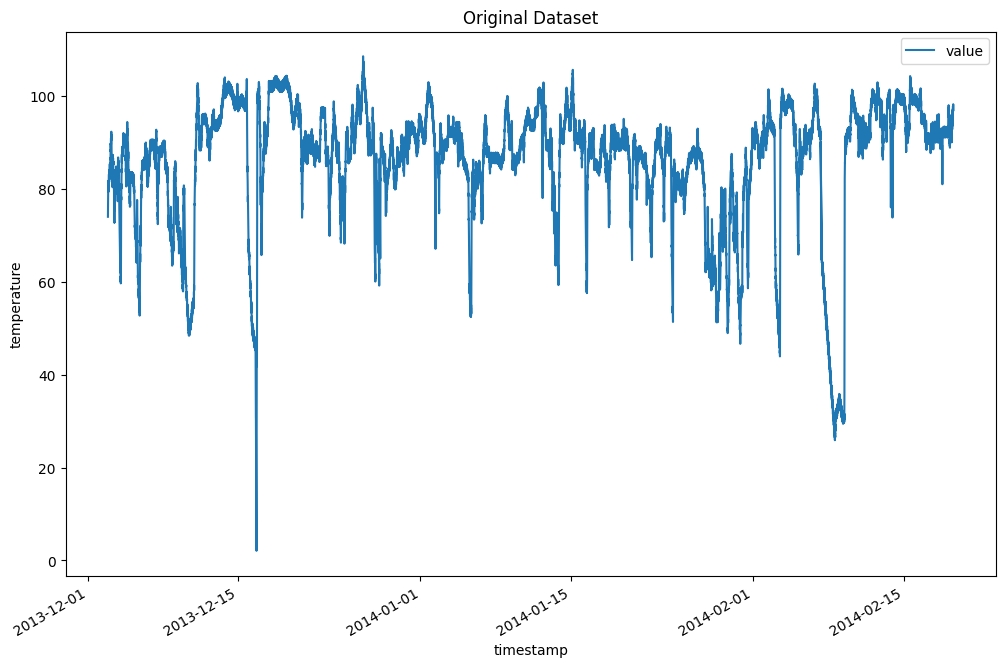

In [41]:
data = raw_dt.copy()
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.plot(x='timestamp', y='value', figsize=(12, 8))
plt.ylabel("temperature")
plt.title("Original Dataset")

In [42]:
data['label'] = 0
instances= [["2013-12-10 06:25:00","2013-12-12 05:35:00"],
            ["2013-12-15 17:50:00","2013-12-17 17:00:00"],
            ["2014-01-27 14:20:00","2014-01-29 13:30:00"],
            ["2014-02-07 14:55:00","2014-02-09 14:05:00"]]


In [43]:
for i in range(len(instances)): 
    start = pd.to_datetime(instances[i][0])
    end = pd.to_datetime(instances[i][1])
    data.loc[(data['timestamp'] >= start) & (data['timestamp'] <= end), 'label'] = 1

In [44]:
data

,timestamp,value,label
0,2013-12-02 21:15:00,73.967322,0
1,2013-12-02 21:20:00,74.935882,0
2,2013-12-02 21:25:00,76.124162,0
3,2013-12-02 21:30:00,78.140707,0
4,2013-12-02 21:35:00,79.329836,0
...,...,...,...
22690,2014-02-19 15:05:00,98.185415,0
22691,2014-02-19 15:10:00,97.804168,0
22692,2014-02-19 15:15:00,97.135468,0
22693,2014-02-19 15:20:00,98.056852,0


In [45]:
data['day'] = data['timestamp'].dt.day
data['month'] = data['timestamp'].dt.month
data['hour_min'] = data['timestamp'].dt.hour + data['timestamp'].dt.minute / 60

data['day_of_week'] = data['timestamp'].dt.dayofweek
data['holiday'] = 0
data.loc[(data['day'] == 25) & (data['month'] == 12),'holiday'] = 1  # Christmas
data.loc[(data['day'] == 1) & (data['month'] == 1),'holiday'] = 1  # New Year's Day
data.head()

,timestamp,value,label,day,month,hour_min,day_of_week,holiday
0,2013-12-02 21:15:00,73.967322,0,2,12,21.250000,0,0
1,2013-12-02 21:20:00,74.935882,0,2,12,21.333333,0,0
2,2013-12-02 21:25:00,76.124162,0,2,12,21.416667,0,0
3,2013-12-02 21:30:00,78.140707,0,2,12,21.500000,0,0
4,2013-12-02 21:35:00,79.329836,0,2,12,21.583333,0,0


In [46]:
holidays = data.loc[data['holiday'] == 1, 'timestamp'].dt.date.unique()
holidays

array([datetime.date(2013, 12, 25), datetime.date(2014, 1, 1)],
      dtype=object)

In [47]:
for i, hd in enumerate(holidays):
    data['hol_' + str(i)] = data['timestamp'].dt.date - hd

In [48]:
for i in range(data.shape[0]):
    if np.abs(data.loc[data.index[i], 'hol_0']) <= np.abs(data.loc[data.index[i], 'hol_1']):
        data.loc[data.index[i], 'gap_holiday'] = data.loc[data.index[i], 'hol_0']
    else:
        data.loc[data.index[i], 'gap_holiday'] = data.loc[data.index[i], 'hol_1']

In [49]:
data['gap_holiday'] = data['gap_holiday'].dt.days
data.drop(['hol_0', 'hol_1'], axis=1, inplace=True)
data['t'] = (data['timestamp'].astype(np.int64)/1e11).astype(np.int64)
data.drop('timestamp', axis=1, inplace=True)
data

,value,label,day,month,hour_min,day_of_week,holiday,gap_holiday,t
0,73.967322,0,2,12,21.250000,0,0,-23,13860189
1,74.935882,0,2,12,21.333333,0,0,-23,13860192
2,76.124162,0,2,12,21.416667,0,0,-23,13860195
3,78.140707,0,2,12,21.500000,0,0,-23,13860198
4,79.329836,0,2,12,21.583333,0,0,-23,13860201
...,...,...,...,...,...,...,...,...,...
22690,98.185415,0,19,2,15.083333,2,0,49,13928223
22691,97.804168,0,19,2,15.166667,2,0,49,13928226
22692,97.135468,0,19,2,15.250000,2,0,49,13928229
22693,98.056852,0,19,2,15.333333,2,0,49,13928232


In [50]:
cont_vars = ['value', 'hour_min', 'gap_holiday', 't']
cat_vars = ['day', 'month', 'day_of_week', 'holiday']

In [51]:
from sklearn.preprocessing import LabelEncoder

label_encoders = [LabelEncoder() for _ in cat_vars] 
for col, enc in zip(cat_vars, label_encoders):
    data[col] = enc.fit_transform(data[col])
    
data= pd.get_dummies(data.iloc[:,:], columns= cat_vars )
data

,value,label,hour_min,gap_holiday,t,day_0,day_1,day_2,day_3,day_4,...,month_2,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,holiday_0,holiday_1
0,73.967322,0,21.250000,-23,13860189,False,True,False,False,False,...,True,True,False,False,False,False,False,False,True,False
1,74.935882,0,21.333333,-23,13860192,False,True,False,False,False,...,True,True,False,False,False,False,False,False,True,False
2,76.124162,0,21.416667,-23,13860195,False,True,False,False,False,...,True,True,False,False,False,False,False,False,True,False
3,78.140707,0,21.500000,-23,13860198,False,True,False,False,False,...,True,True,False,False,False,False,False,False,True,False
4,79.329836,0,21.583333,-23,13860201,False,True,False,False,False,...,True,True,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22690,98.185415,0,15.083333,49,13928223,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
22691,97.804168,0,15.166667,49,13928226,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
22692,97.135468,0,15.250000,49,13928229,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
22693,98.056852,0,15.333333,49,13928232,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False


In [52]:
# Splitting to train and test
test_ratio = 0.7
tr_data = data.iloc[: int(len(data) * (1 - test_ratio))]
tst_data = data.iloc[int(len(data) * (1 - test_ratio)) :]

In [53]:
scaler = preprocessing.StandardScaler().fit(tr_data[cont_vars])

In [54]:
tr_data_scaled = tr_data.copy()
tr_data_scaled[cont_vars] = scaler.transform(tr_data[cont_vars])
tst_data_scaled = tst_data.copy()
tst_data_scaled[cont_vars] = scaler.transform(tst_data[cont_vars])

In [55]:
tr_data_scaled.head()

,value,label,hour_min,gap_holiday,t,day_0,day_1,day_2,day_3,day_4,...,month_2,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,holiday_0,holiday_1
0,-0.903546,0,1.348301,-1.787205,-1.731796,False,True,False,False,False,...,True,True,False,False,False,False,False,False,True,False
1,-0.833583,0,1.360296,-1.787205,-1.731288,False,True,False,False,False,...,True,True,False,False,False,False,False,False,True,False
2,-0.747749,0,1.372292,-1.787205,-1.730779,False,True,False,False,False,...,True,True,False,False,False,False,False,False,True,False
3,-0.602085,0,1.384287,-1.787205,-1.730270,False,True,False,False,False,...,True,True,False,False,False,False,False,False,True,False
4,-0.516190,0,1.396282,-1.787205,-1.729761,False,True,False,False,False,...,True,True,False,False,False,False,False,False,True,False


In [56]:
tst_data_scaled.head()

,value,label,hour_min,gap_holiday,t,day_0,day_1,day_2,day_3,day_4,...,month_2,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,holiday_0,holiday_1
6808,0.896816,0,0.100777,1.726307,1.732305,False,False,False,False,False,...,True,False,False,False,True,False,False,False,True,False
6809,0.986810,0,0.112772,1.726307,1.732814,False,False,False,False,False,...,True,False,False,False,True,False,False,False,True,False
6810,0.972811,0,0.124768,1.726307,1.733323,False,False,False,False,False,...,True,False,False,False,True,False,False,False,True,False
6811,1.042576,0,0.136763,1.726307,1.733832,False,False,False,False,False,...,True,False,False,False,True,False,False,False,True,False
6812,0.914524,0,0.148759,1.726307,1.734341,False,False,False,False,False,...,True,False,False,False,True,False,False,False,True,False


In [58]:
train= tr_data_scaled.drop(columns=['label'])

In [60]:
labels_of_test = tst_data_scaled['label'].tolist()
test= tst_data_scaled.drop(columns=['label'])

In [61]:
train= train.to_numpy()
train= np.asarray(train).astype(np.float32)
test= test.to_numpy()
test= np.asarray(test).astype(np.float32)

In [62]:
def get_error_term(v1, v2, _rmse=True):
    if _rmse:
        return np.sqrt(np.mean((v1 - v2) ** 2, axis=1))
    #return MAE
    return np.mean(abs(v1 - v2), axis=1)

In [63]:
def sample(args):
    z_mean, z_log_var = args
    batch = tf.keras.backend.shape(z_mean)[0]
    dim = tf.keras.backend.int_shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.keras.backend.exp(0.5 * z_log_var) * epsilon

In [64]:
class VAELossLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(VAELossLayer, self).__init__(**kwargs)

    def call(self, inputs):
        x, x_decoded_mean, z_mean, z_log_var = inputs
        # compute the average MSE error, then scale it up, i.e. simply sum on all axes
        reconstruction_loss = tf.reduce_sum(tf.square(x - x_decoded_mean))
        # compute the KL loss
        kl_loss = - 0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
        # return the average loss over all 
        total_loss = tf.reduce_mean(reconstruction_loss + kl_loss)    
        self.add_loss(total_loss)
        return x  # Dummy output

In [65]:
original_dim = train.shape[1]
input_shape = (original_dim,)
intermediate_dim = int(original_dim / 2)
latent_dim = int(original_dim / 3)

In [66]:
print(input_shape)

(47,)


In [67]:
# encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
# use the reparameterization trick and get the output from the sample() function
z = Lambda(sample, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder = Model(inputs, z, name='encoder')
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 47)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 23)        │      1,104 │ encoder_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 15)        │        360 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 15)        │        360 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Lambda)          │ (None, 15)        │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,824 (7.12 KB)

 Trainable params: 1,824 (7.12 KB)

 Non-trainable params: 0 (0.00 B)

In [68]:
# decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)
# Instantiate the decoder model:
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ z_sampling (InputLayer)         │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 23)             │           368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 47)             │         1,128 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,496 (5.84 KB)

 Trainable params: 1,496 (5.84 KB)

 Non-trainable params: 0 (0.00 B)

In [70]:
# full VAE model
inputs = Input(shape=input_shape, name='encoder_input')

x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
# Use the reparameterization trick and get the output from the sample() function
z = Lambda(sample, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder = Model(inputs, z, name='encoder')

# Decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)
decoder = Model(latent_inputs, outputs, name='decoder')

outputs = decoder(encoder(inputs))
vae_loss_layer = VAELossLayer()([inputs, outputs, z_mean, z_log_var])

vae_model = Model(inputs, [outputs, vae_loss_layer], name='vae_mlp')

In [71]:
opt = optimizers.Adam(learning_rate=0.0001, clipvalue=0.5)
#opt = optimizers.RMSprop(learning_rate=0.0001)

vae_model.compile(optimizer=opt, loss=lambda y_true, y_pred: y_pred)
vae_model.summary()
# Finally, we train the model:
results = vae_model.fit(train,train, 
                        shuffle=True,
                        epochs=100,
                        batch_size=256)

Model: "vae_mlp"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 47)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder             │ (None, 15)        │      1,824 │ encoder_input[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 23)        │      1,104 │ encoder_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder             │ (None, 47)        │      1,496 │ encoder[0][0]     │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 15)        │        360 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 15)        │        360 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vae_loss_layer_1    │ (None, 47)        │          0 │ encoder_input[0]… │
│ (VAELossLayer)      │                   │            │ decoder[0][0],    │
│                     │                   │            │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,320 (12.97 KB)

 Trainable params: 3,320 (12.97 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 4214.9424
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4130.0698
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4046.8813
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3959.3018
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3892.9243
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3810.0996
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3729.8613
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3635.6707
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3577.0781
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3484.4854
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3390.7957
Epoch 12/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3319.4106
Epoch 13/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3235.0833
Epoch 14/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3161.9551
Epoch 15/100
27/27 ━━━━━━━━━━

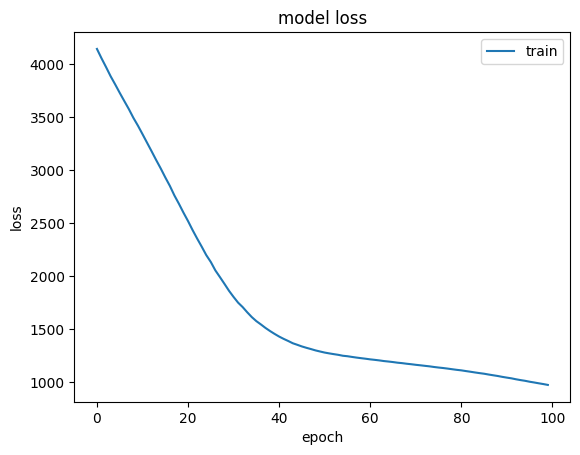

In [72]:
plt.plot(results.history['loss'])
#plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');
plt.show()

In [73]:
train_pred = vae_model.predict(train)[0]

213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [74]:
mae_vector = get_error_term(train_pred, train, _rmse=False)
print(f'Avg error {np.mean(mae_vector)}\nmedian error {np.median(mae_vector)}\n99Q: {np.quantile(mae_vector, 0.99)}')
print(f'setting threshold on { np.quantile(mae_vector, 0.99)} ')

error_thresh = np.quantile(mae_vector, 0.99)

Avg error 0.11121687293052673
median error 0.10800415277481079
99Q: 0.18360431715846062
setting threshold on 0.18360431715846062 


In [75]:
X_pred = vae_model.predict(test)[0]
mae_vector = get_error_term(X_pred, test, _rmse=False)
anomalies = (mae_vector > error_thresh)

np.count_nonzero(anomalies) / len(anomalies)

497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


0.9044501793919557

In [76]:
from sklearn.metrics import classification_report
# y_test contains the labels of anomaly =1
print(classification_report(labels_of_test, anomalies))

              precision    recall  f1-score   support

           0       1.00      0.10      0.19     14753
           1       0.08      1.00      0.15      1134

    accuracy                           0.17     15887
   macro avg       0.54      0.55      0.17     15887
weighted avg       0.93      0.17      0.18     15887



In [78]:
encoded = encoder.predict(test)

497/497 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [79]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
transform = pca.fit_transform(encoded)

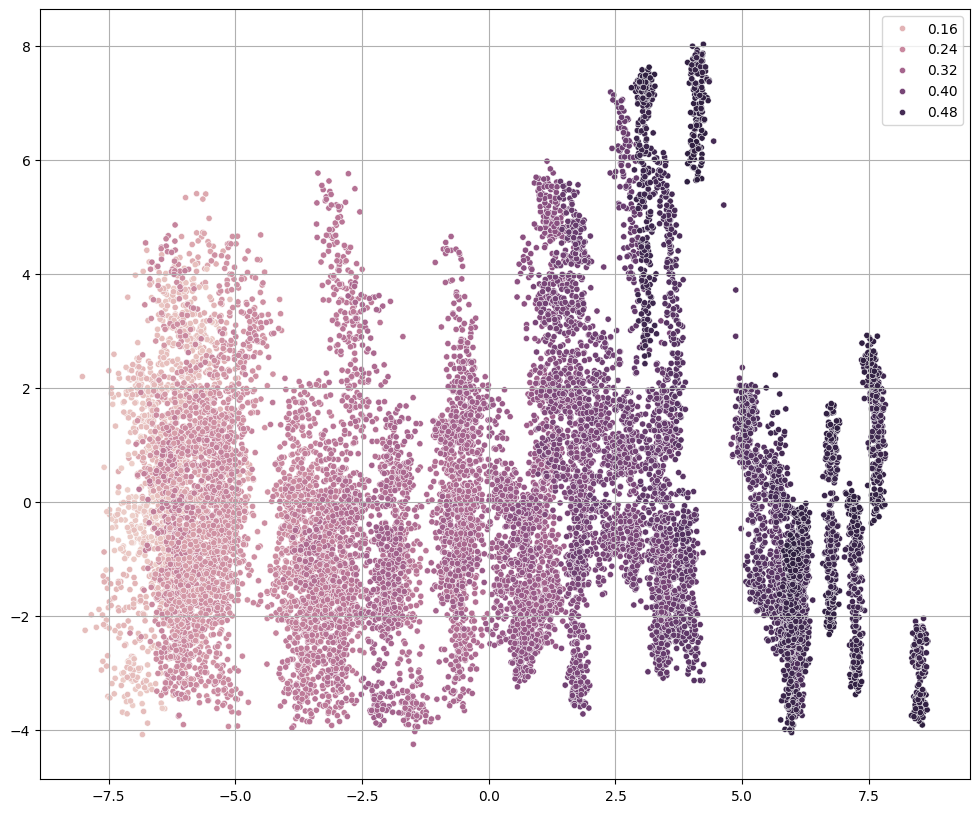

In [80]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x=transform[:, 0], y=transform[:, 1], s=20, hue=mae_vector)
plt.grid()
plt.show()

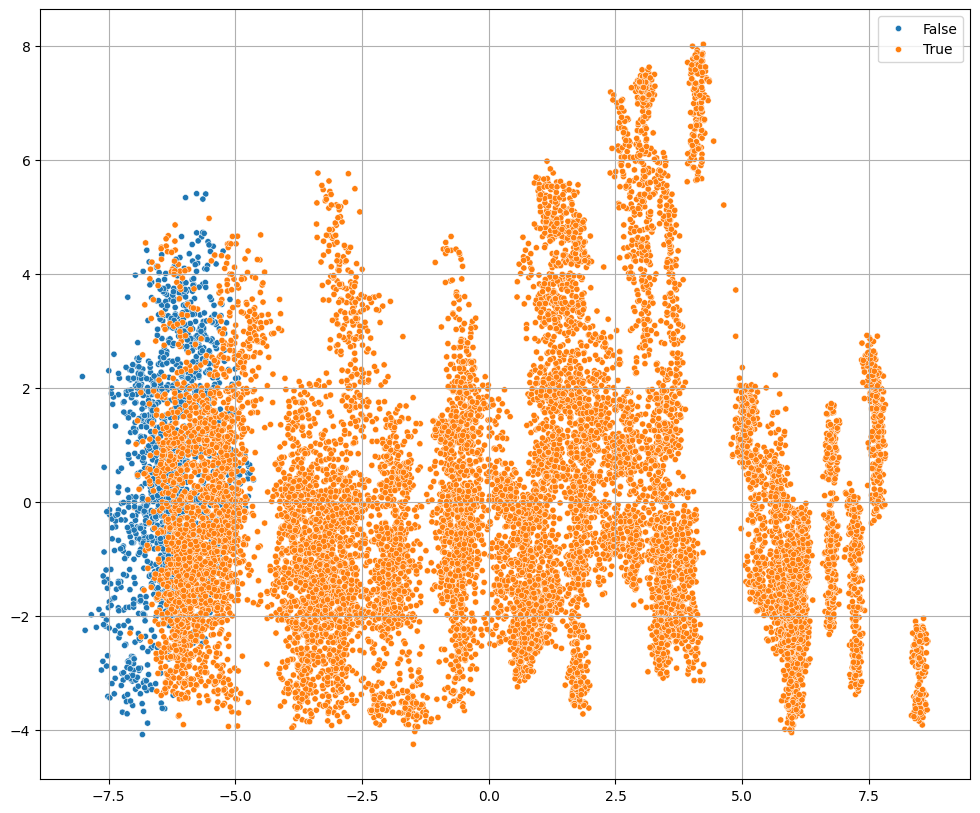

In [81]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x=transform[:, 0], y=transform[:, 1], s=20, hue=anomalies)
plt.grid()
plt.show()

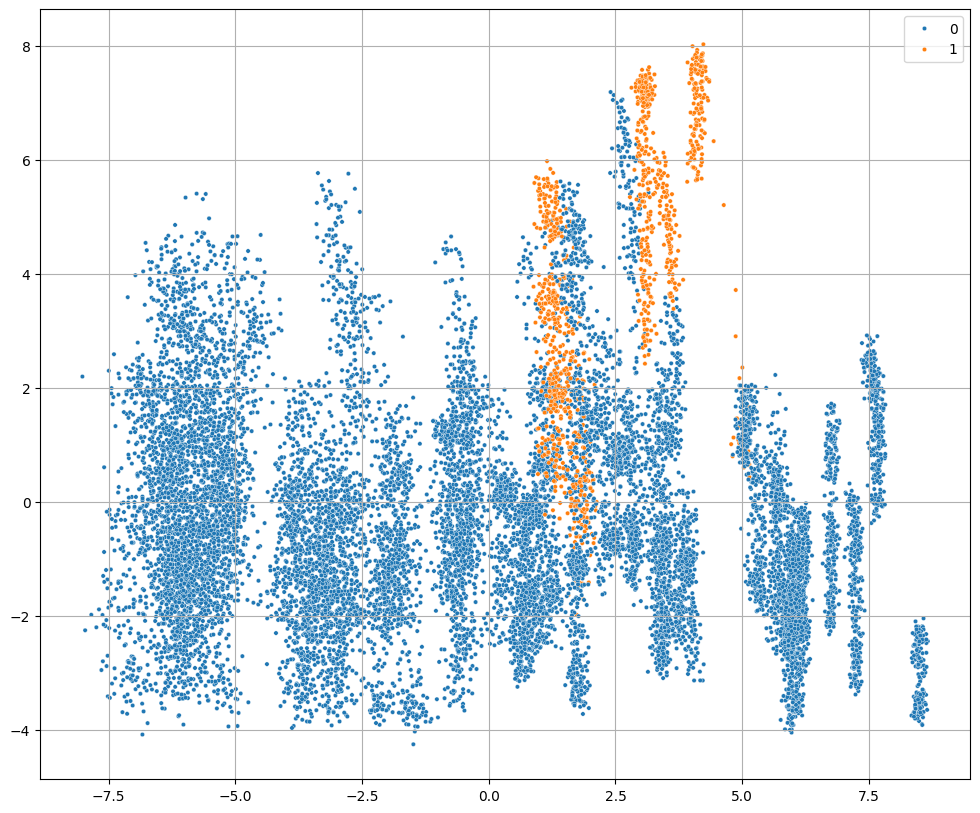

In [82]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x=transform[:, 0], y=transform[:, 1], s=10, hue=labels_of_test)
plt.grid()
plt.show()